# Method 4 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

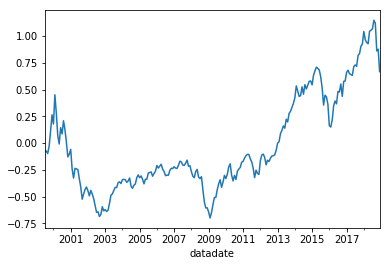

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.264418
2000-12-31   -0.291682
2001-12-31   -0.341977
2002-12-31   -0.378465
2003-12-31    0.697217
2004-12-31    0.130622
2005-12-31    0.049774
2006-12-31    0.032340
2007-12-31    0.035088
2008-12-31   -0.498971
2009-12-31    0.767184
2010-12-31    0.176376
2011-12-31   -0.139366
2012-12-31    0.320453
2013-12-31    0.469043
2014-12-31    0.152976
2015-12-31   -0.138401
2016-12-31    0.160098
2017-12-31    0.218940
2018-12-31   -0.133729
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     447.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.75e-107
Time:                        11:49:56   Log-Likelihood:                 525.98
No. Observations:                 234   AIC:                            -1042.
Df Residuals:                     229   BIC:                            -1025.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.585      0.559      -0.002       0.004
mktrf          1.1557      0.048     23.983      0.000       1.061       1.251
me             0.5220      0.056      9.313      0.000       0.412       0.632
ia            -0.2441      0.085     -2.865      0.005      -0.412      -0.076
roe           -0.5812      0.073     -7.970      0.000      -0.725      -0.437
==============================================================================
Omnibus:                       19.349   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.426
Skew:                           0.374   Prob(JB):                     6.13e-10
Kurtosis:                       4.947   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     293.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.16e-89
Time:                        11:49:56   Log-Likelihood:                 525.98
No. Observations:                 234   AIC:                            -1042.
Df Residuals:                     229   BIC:                            -1025.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.512      0.609      -0.003       0.005
mktrf          1.1557      0.063     18.218      0.000       1.031       1.280
me             0.5220      0.075      6.948      0.000       0.375       0.669
ia            -0.2441      0.124     -1.962      0.050      -0.488      -0.000
roe           -0.5812      0.137     -4.228      0.000      -0.851      -0.312
==============================================================================
Omnibus:                       19.349   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.426
Skew:                           0.374   Prob(JB):                     6.13e-10
Kurtosis:                       4.947   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     411.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.06e-103
Time:                        11:49:56   Log-Likelihood:                 525.98
No. Observations:                 234   AIC:                            -1042.
Df Residuals:                     229   BIC:                            -1025.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.499      0.618      -0.003       0.005
mktrf          1.1557      0.060     19.134      0.000       1.037       1.274
me             0.5220      0.077      6.818      0.000       0.372       0.672
ia            -0.2441      0.096     -2.553      0.011      -0.431      -0.057
roe           -0.5812      0.149     -3.894      0.000      -0.874      -0.289
==============================================================================
Omnibus:                       19.349   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.426
Skew:                           0.374   Prob(JB):                     6.13e-10
Kurtosis:                       4.947   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     341.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.77e-104
Time:                        11:49:56   Log-Likelihood:                 521.54
No. Observations:                 234   AIC:                            -1031.
Df Residuals:                     228   BIC:                            -1010.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.484      0.629      -0.003       0.004
mktrf          1.2122      0.049     24.580      0.000       1.115       1.309
smb            0.5118      0.065      7.864      0.000       0.384       0.640
hml           -0.0399      0.077     -0.520      0.604      -0.191       0.111
rmw           -0.5981      0.087     -6.894      0.000      -0.769      -0.427
cma           -0.0215      0.110     -0.195      0.845      -0.239       0.196
==============================================================================
Omnibus:                       30.606   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.271
Skew:                           0.700   Prob(JB):                     9.95e-13
Kurtosis:                       4.926   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     262.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-92
Time:                        11:49:56   Log-Likelihood:                 521.54
No. Observations:                 234   AIC:                            -1031.
Df Residuals:                     228   BIC:                            -1010.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.503      0.615      -0.003       0.004
mktrf          1.2122      0.056     21.713      0.000       1.103       1.322
smb            0.5118      0.051      9.993      0.000       0.411       0.612
hml           -0.0399      0.103     -0.386      0.699      -0.242       0.162
rmw           -0.5981      0.119     -5.042      0.000      -0.831      -0.366
cma           -0.0215      0.143     -0.150      0.881      -0.302       0.259
==============================================================================
Omnibus:                       30.606   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.271
Skew:                           0.700   Prob(JB):                     9.95e-13
Kurtosis:                       4.926   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     352.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.44e-105
Time:                        11:49:56   Log-Likelihood:                 521.54
No. Observations:                 234   AIC:                            -1031.
Df Residuals:                     228   BIC:                            -1010.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.546      0.585      -0.002       0.004
mktrf          1.2122      0.061     19.908      0.000       1.093       1.332
smb            0.5118      0.047     10.976      0.000       0.420       0.603
hml           -0.0399      0.084     -0.473      0.636      -0.205       0.125
rmw           -0.5981      0.122     -4.883      0.000      -0.838      -0.358
cma           -0.0215      0.118     -0.182      0.856      -0.253       0.210
==============================================================================
Omnibus:                       30.606   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.271
Skew:                           0.700   Prob(JB):                     9.95e-13
Kurtosis:                       4.926   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     371.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.25e-99
Time:                        11:49:56   Log-Likelihood:                 506.77
No. Observations:                 234   AIC:                            -1004.
Df Residuals:                     229   BIC:                            -986.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.758      0.449      -0.005       0.002
mktrf          1.3005      0.048     27.002      0.000       1.206       1.395
smb            0.7433      0.060     12.364      0.000       0.625       0.862
hml           -0.1483      0.060     -2.482      0.014      -0.266      -0.031
umd           -0.1471      0.039     -3.755      0.000      -0.224      -0.070
==============================================================================
Omnibus:                       18.374   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.654
Skew:                           0.510   Prob(JB):                     1.63e-06
Kurtosis:                       4.301   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     212.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.95e-76
Time:                        11:49:56   Log-Likelihood:                 506.77
No. Observations:                 234   AIC:                            -1004.
Df Residuals:                     229   BIC:                            -986.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.770      0.441      -0.005       0.002
mktrf          1.3005      0.058     22.271      0.000       1.186       1.415
smb            0.7433      0.086      8.644      0.000       0.575       0.912
hml           -0.1483      0.081     -1.827      0.068      -0.307       0.011
umd           -0.1471      0.073     -2.019      0.044      -0.290      -0.004
==============================================================================
Omnibus:                       18.374   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.654
Skew:                           0.510   Prob(JB):                     1.63e-06
Kurtosis:                       4.301   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     210.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-75
Time:                        11:49:56   Log-Likelihood:                 506.77
No. Observations:                 234   AIC:                            -1004.
Df Residuals:                     229   BIC:                            -986.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.825      0.409      -0.005       0.002
mktrf          1.3005      0.063     20.699      0.000       1.177       1.424
smb            0.7433      0.072     10.338      0.000       0.602       0.884
hml           -0.1483      0.067     -2.200      0.028      -0.280      -0.016
umd           -0.1471      0.078     -1.896      0.058      -0.299       0.005
==============================================================================
Omnibus:                       18.374   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.654
Skew:                           0.510   Prob(JB):                     1.63e-06
Kurtosis:                       4.301   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     242.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.98e-55
Time:                        11:49:56   Log-Likelihood:                 254.84
No. Observations:                 120   AIC:                            -499.7
Df Residuals:                     115   BIC:                            -485.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.179      0.859      -0.006       0.005
mktrf          1.2424      0.076     16.306      0.000       1.091       1.393
me             0.5710      0.075      7.587      0.000       0.422       0.720
ia            -0.2857      0.118     -2.425      0.017      -0.519      -0.052
roe           -0.4161      0.104     -3.989      0.000      -0.623      -0.209
==============================================================================
Omnibus:                       10.351   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.564
Skew:                           0.440   Prob(JB):                     0.000688
Kurtosis:                       4.462   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     158.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.90e-46
Time:                        11:49:56   Log-Likelihood:                 254.84
No. Observations:                 120   AIC:                            -499.7
Df Residuals:                     115   BIC:                            -485.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.004     -0.143      0.887      -0.007       0.006
mktrf          1.2424      0.101     12.343      0.000       1.045       1.440
me             0.5710      0.108      5.311      0.000       0.360       0.782
ia            -0.2857      0.176     -1.627      0.104      -0.630       0.058
roe           -0.4161      0.191     -2.182      0.029      -0.790      -0.042
==============================================================================
Omnibus:                       10.351   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.564
Skew:                           0.440   Prob(JB):                     0.000688
Kurtosis:                       4.462   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     233.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.00e-54
Time:                        11:49:56   Log-Likelihood:                 254.84
No. Observations:                 120   AIC:                            -499.7
Df Residuals:                     115   BIC:                            -485.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.004     -0.140      0.889      -0.008       0.007
mktrf          1.2424      0.091     13.592      0.000       1.063       1.422
me             0.5710      0.114      4.998      0.000       0.347       0.795
ia            -0.2857      0.145     -1.975      0.048      -0.569      -0.002
roe           -0.4161      0.200     -2.081      0.037      -0.808      -0.024
==============================================================================
Omnibus:                       10.351   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.564
Skew:                           0.440   Prob(JB):                     0.000688
Kurtosis:                       4.462   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     214.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-56
Time:                        11:49:56   Log-Likelihood:                 260.89
No. Observations:                 120   AIC:                            -509.8
Df Residuals:                     114   BIC:                            -493.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.468      0.641      -0.004       0.007
mktrf          1.3249      0.077     17.268      0.000       1.173       1.477
smb            0.5419      0.087      6.236      0.000       0.370       0.714
hml           -0.1533      0.106     -1.440      0.153      -0.364       0.058
rmw           -0.4479      0.126     -3.567      0.001      -0.697      -0.199
cma            0.0674      0.138      0.490      0.625      -0.205       0.340
==============================================================================
Omnibus:                       14.030   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.873
Skew:                           0.653   Prob(JB):                     0.000131
Kurtosis:                       4.367   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     314.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.94e-65
Time:                        11:49:56   Log-Likelihood:                 260.89
No. Observations:                 120   AIC:                            -509.8
Df Residuals:                     114   BIC:                            -493.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.472      0.637      -0.004       0.007
mktrf          1.3249      0.068     19.362      0.000       1.191       1.459
smb            0.5419      0.071      7.612      0.000       0.402       0.681
hml           -0.1533      0.119     -1.288      0.198      -0.387       0.080
rmw           -0.4479      0.153     -2.935      0.003      -0.747      -0.149
cma            0.0674      0.169      0.399      0.690      -0.264       0.399
==============================================================================
Omnibus:                       14.030   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.873
Skew:                           0.653   Prob(JB):                     0.000131
Kurtosis:                       4.367   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     620.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.67e-81
Time:                        11:49:56   Log-Likelihood:                 260.89
No. Observations:                 120   AIC:                            -509.8
Df Residuals:                     114   BIC:                            -493.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.495      0.621      -0.004       0.006
mktrf          1.3249      0.064     20.830      0.000       1.200       1.450
smb            0.5419      0.069      7.817      0.000       0.406       0.678
hml           -0.1533      0.099     -1.552      0.121      -0.347       0.040
rmw           -0.4479      0.164     -2.737      0.006      -0.769      -0.127
cma            0.0674      0.131      0.514      0.608      -0.190       0.325
==============================================================================
Omnibus:                       14.030   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.873
Skew:                           0.653   Prob(JB):                     0.000131
Kurtosis:                       4.367   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     243.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.13e-55
Time:                        11:49:56   Log-Likelihood:                 255.04
No. Observations:                 120   AIC:                            -500.1
Df Residuals:                     115   BIC:                            -486.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.286      0.776      -0.006       0.005
mktrf          1.4095      0.067     21.034      0.000       1.277       1.542
smb            0.7196      0.076      9.432      0.000       0.569       0.871
hml           -0.1803      0.076     -2.360      0.020      -0.332      -0.029
umd           -0.0922      0.047     -1.957      0.053      -0.186       0.001
==============================================================================
Omnibus:                        9.312   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.663
Skew:                           0.489   Prob(JB):                      0.00484
Kurtosis:                       4.084   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     288.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.39e-59
Time:                        11:49:57   Log-Likelihood:                 255.04
No. Observations:                 120   AIC:                            -500.1
Df Residuals:                     115   BIC:                            -486.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.281      0.779      -0.006       0.005
mktrf          1.4095      0.057     24.722      0.000       1.298       1.521
smb            0.7196      0.101      7.105      0.000       0.521       0.918
hml           -0.1803      0.092     -1.967      0.049      -0.360      -0.001
umd           -0.0922      0.074     -1.239      0.215      -0.238       0.054
==============================================================================
Omnibus:                        9.312   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.663
Skew:                           0.489   Prob(JB):                      0.00484
Kurtosis:                       4.084   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     391.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.03e-66
Time:                        11:49:57   Log-Likelihood:                 255.04
No. Observations:                 120   AIC:                            -500.1
Df Residuals:                     115   BIC:                            -486.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.299      0.765      -0.006       0.004
mktrf          1.4095      0.046     30.407      0.000       1.319       1.500
smb            0.7196      0.088      8.162      0.000       0.547       0.892
hml           -0.1803      0.075     -2.414      0.016      -0.327      -0.034
umd           -0.0922      0.076     -1.215      0.224      -0.241       0.057
==============================================================================
Omnibus:                        9.312   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.663
Skew:                           0.489   Prob(JB):                      0.00484
Kurtosis:                       4.084   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     203.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-49
Time:                        11:49:57   Log-Likelihood:                 283.87
No. Observations:                 114   AIC:                            -557.7
Df Residuals:                     109   BIC:                            -544.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.560      0.122      -0.001       0.007
mktrf          1.0804      0.060     17.914      0.000       0.961       1.200
me             0.4349      0.093      4.670      0.000       0.250       0.619
ia            -0.2195      0.129     -1.700      0.092      -0.476       0.036
roe           -0.9262      0.113     -8.161      0.000      -1.151      -0.701
==============================================================================
Omnibus:                       38.560   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.320
Skew:                           1.090   Prob(JB):                     2.78e-32
Kurtosis:                       8.083   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     212.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-50
Time:                        11:49:57   Log-Likelihood:                 283.87
No. Observations:                 114   AIC:                            -557.7
Df Residuals:                     109   BIC:                            -544.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      2.015      0.044    8.77e-05       0.006
mktrf          1.0804      0.060     18.090      0.000       0.963       1.197
me             0.4349      0.050      8.669      0.000       0.337       0.533
ia            -0.2195      0.105     -2.098      0.036      -0.425      -0.014
roe           -0.9262      0.094     -9.812      0.000      -1.111      -0.741
==============================================================================
Omnibus:                       38.560   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.320
Skew:                           1.090   Prob(JB):                     2.78e-32
Kurtosis:                       8.083   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     291.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-57
Time:                        11:49:57   Log-Likelihood:                 283.87
No. Observations:                 114   AIC:                            -557.7
Df Residuals:                     109   BIC:                            -544.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      2.004      0.045    6.99e-05       0.006
mktrf          1.0804      0.052     20.697      0.000       0.978       1.183
me             0.4349      0.041     10.677      0.000       0.355       0.515
ia            -0.2195      0.104     -2.103      0.035      -0.424      -0.015
roe           -0.9262      0.074    -12.462      0.000      -1.072      -0.781
==============================================================================
Omnibus:                       38.560   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.320
Skew:                           1.090   Prob(JB):                     2.78e-32
Kurtosis:                       8.083   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     109.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-40
Time:                        11:49:57   Log-Likelihood:                 264.72
No. Observations:                 114   AIC:                            -517.4
Df Residuals:                     108   BIC:                            -501.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.362      0.718      -0.004       0.006
mktrf          1.1227      0.068     16.424      0.000       0.987       1.258
smb            0.5107      0.111      4.602      0.000       0.291       0.731
hml            0.0522      0.142      0.369      0.713      -0.228       0.333
rmw           -0.7285      0.173     -4.204      0.000      -1.072      -0.385
cma           -0.1138      0.220     -0.517      0.606      -0.550       0.322
==============================================================================
Omnibus:                       19.561   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.710
Skew:                           0.713   Prob(JB):                     1.07e-08
Kurtosis:                       5.386   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     97.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-38
Time:                        11:49:57   Log-Likelihood:                 264.72
No. Observations:                 114   AIC:                            -517.4
Df Residuals:                     108   BIC:                            -501.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.425      0.671      -0.003       0.005
mktrf          1.1227      0.073     15.355      0.000       0.979       1.266
smb            0.5107      0.072      7.058      0.000       0.369       0.653
hml            0.0522      0.143      0.366      0.715      -0.228       0.332
rmw           -0.7285      0.202     -3.609      0.000      -1.124      -0.333
cma           -0.1138      0.196     -0.580      0.562      -0.498       0.271
==============================================================================
Omnibus:                       19.561   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.710
Skew:                           0.713   Prob(JB):                     1.07e-08
Kurtosis:                       5.386   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     150.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.99e-47
Time:                        11:49:57   Log-Likelihood:                 264.72
No. Observations:                 114   AIC:                            -517.4
Df Residuals:                     108   BIC:                            -501.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.480      0.631      -0.003       0.004
mktrf          1.1227      0.074     15.179      0.000       0.978       1.268
smb            0.5107      0.066      7.783      0.000       0.382       0.639
hml            0.0522      0.159      0.329      0.742      -0.259       0.363
rmw           -0.7285      0.178     -4.089      0.000      -1.078      -0.379
cma           -0.1138      0.219     -0.520      0.603      -0.543       0.315
==============================================================================
Omnibus:                       19.561   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.710
Skew:                           0.713   Prob(JB):                     1.07e-08
Kurtosis:                       5.386   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     123.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-39
Time:                        11:49:57   Log-Likelihood:                 259.48
No. Observations:                 114   AIC:                            -509.0
Df Residuals:                     109   BIC:                            -495.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.073      0.942      -0.005       0.005
mktrf          1.1483      0.071     16.221      0.000       1.008       1.289
smb            0.6840      0.110      6.197      0.000       0.465       0.903
hml            0.0133      0.114      0.117      0.907      -0.212       0.239
umd           -0.2504      0.086     -2.920      0.004      -0.420      -0.080
==============================================================================
Omnibus:                       14.701   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.560
Skew:                           0.629   Prob(JB):                     2.08e-05
Kurtosis:                       4.719   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     107.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.50e-37
Time:                        11:49:57   Log-Likelihood:                 259.48
No. Observations:                 114   AIC:                            -509.0
Df Residuals:                     109   BIC:                            -495.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.087      0.931      -0.004       0.004
mktrf          1.1483      0.082     14.048      0.000       0.988       1.308
smb            0.6840      0.089      7.700      0.000       0.510       0.858
hml            0.0133      0.170      0.078      0.938      -0.320       0.347
umd           -0.2504      0.122     -2.057      0.040      -0.489      -0.012
==============================================================================
Omnibus:                       14.701   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.560
Skew:                           0.629   Prob(JB):                     2.08e-05
Kurtosis:                       4.719   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     150.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.88e-43
Time:                        11:49:57   Log-Likelihood:                 259.48
No. Observations:                 114   AIC:                            -509.0
Df Residuals:                     109   BIC:                            -495.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.091      0.928      -0.004       0.004
mktrf          1.1483      0.080     14.348      0.000       0.991       1.305
smb            0.6840      0.070      9.815      0.000       0.547       0.821
hml            0.0133      0.176      0.075      0.940      -0.332       0.359
umd           -0.2504      0.118     -2.130      0.033      -0.481      -0.020
==============================================================================
Omnibus:                       14.701   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.560
Skew:                           0.629   Prob(JB):                     2.08e-05
Kurtosis:                       4.719   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""